# Import Dependencies

In [79]:
import numpy as np 
import matplotlib.pyplot as plt 

import pandas as pd 
from pandas.plotting import autocorrelation_plot
from pandas.tseries.offsets import DateOffset

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.arima.model import ARIMA

from sklearn.metrics import mean_squared_error, mean_absolute_error

%matplotlib inline

# Loading the Data

In [80]:
df = pd.read_csv('data/perrin-freres-monthly-champagne-.csv')
df.tail()

,Month,Perrin Freres monthly champagne sales millions ?64-?72
102,1972-07,4298.0
103,1972-08,1413.0
104,1972-09,5877.0
105,NaN,NaN
106,Perrin Freres monthly champagne sales millions...,NaN


# Preprocessing

In [81]:
# Changing the column names
df.columns = ['Month', 'Sales']
df.tail()

,Month,Sales
102,1972-07,4298.0
103,1972-08,1413.0
104,1972-09,5877.0
105,NaN,NaN
106,Perrin Freres monthly champagne sales millions...,NaN


In [82]:
# Dropping the unnecessary rows
df.drop([105, 106], axis=0, inplace=True)
df.tail()

,Month,Sales
100,1972-05,4618.0
101,1972-06,5312.0
102,1972-07,4298.0
103,1972-08,1413.0
104,1972-09,5877.0


In [83]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105 entries, 0 to 104
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Month   105 non-null    object 
 1   Sales   105 non-null    float64
dtypes: float64(1), object(1)
memory usage: 1.8+ KB


In [84]:
# Chaning the type of 'Month' column
df['Month'] = pd.to_datetime(df['Month'])
df.head()

,Month,Sales
0,1964-01-01,2815.0
1,1964-02-01,2672.0
2,1964-03-01,2755.0
3,1964-04-01,2721.0
4,1964-05-01,2946.0


In [85]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105 entries, 0 to 104
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Month   105 non-null    datetime64[ns]
 1   Sales   105 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 1.8 KB


In [86]:
# Setting Month as the index
df.set_index('Month', inplace=True)
df.head()

,Sales
Month,
1964-01-01,2815.0
1964-02-01,2672.0
1964-03-01,2755.0
1964-04-01,2721.0
1964-05-01,2946.0


### Visualizing the Data

<AxesSubplot:xlabel='Month'>

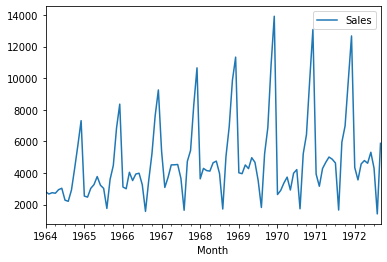

In [87]:
df.plot()

<p>We can infer that the data distribution is <b>seasonal</b></p>

### Checking if the data is stationary

In [88]:
test_result=adfuller(df['Sales'])

In [89]:
#Ho: It is non stationary
#H1: It is stationary

def adfuller_test(sales):
    result=adfuller(sales)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("Data is stationary")
    else:
        print("Data is non-stationary ")

In [90]:
adfuller_test(df['Sales'])

ADF Test Statistic : -1.8335930563276195
p-value : 0.3639157716602467
#Lags Used : 11
Number of Observations Used : 93
Data is non-stationary 


### Making the data Stationary

In [91]:
# Differencing the annual sales
df['Seasonal First Difference']=df['Sales']-df['Sales'].shift(12)
df.head(15)

,Sales,Seasonal First Difference
Month,,
1964-01-01,2815.0,NaN
1964-02-01,2672.0,NaN
1964-03-01,2755.0,NaN
1964-04-01,2721.0,NaN
1964-05-01,2946.0,NaN
1964-06-01,3036.0,NaN
1964-07-01,2282.0,NaN
1964-08-01,2212.0,NaN
1964-09-01,2922.0,NaN


In [92]:
# Testing the difference
adfuller_test(df['Seasonal First Difference'].dropna())

ADF Test Statistic : -7.626619157213164
p-value : 2.060579696813685e-11
#Lags Used : 0
Number of Observations Used : 92
Data is stationary


<AxesSubplot:xlabel='Month'>

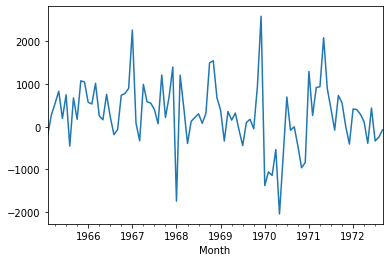

In [93]:
# Plotting the new data
df['Seasonal First Difference'].iloc[13:].plot()

# Auto Regressive Model

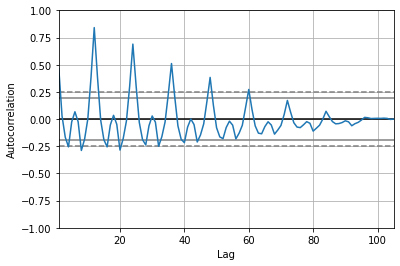

In [94]:
autocorrelation_plot(df['Sales'])
plt.show()

C:\Users\owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


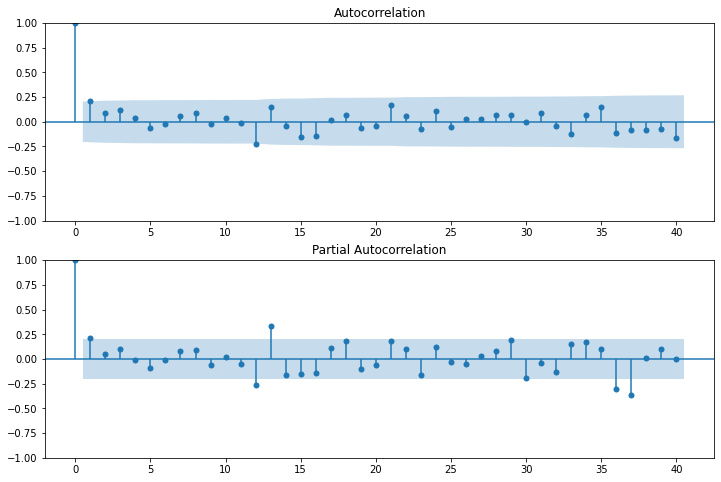

In [95]:
# We use partial auto correlation (PACF) to get the AR model
# Plotting ACF and PACF
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = plot_acf(df['Seasonal First Difference'].iloc[13:],lags=40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(df['Seasonal First Difference'].iloc[13:],lags=40,ax=ax2)

# ARIMA

P = 1 [Since there is a drop at x=1 in PACF]  
Q = 0 [Since there is no exponential trend in ACF]  
D = 1 [Since we only made a seasonal difference once]

In [96]:
model=ARIMA(df['Sales'],order=(1,1,1)) # order is p,d,q
model_fit=model.fit()

C:\Users\owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [97]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Sales   No. Observations:                  105
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -952.814
Date:                Mon, 22 Jan 2024   AIC                           1911.627
Time:                        05:17:48   BIC                           1919.560
Sample:                    01-01-1964   HQIC                          1914.841
                         - 09-01-1972                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4545      0.114      3.999      0.000       0.232       0.677
ma.L1         -0.9666      0.056    -17.316      0.000      -1.076      -0.857
sigma2      5.226e+06   6.17e+05      8.473      0.000    4.02e+06    6.43e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.91   Jarque-Bera (JB):                 2.59
Prob(Q):                              0.34   Prob(JB):                         0.27
Heteroskedasticity (H):               3.40   Skew:                             0.05
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.77
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<AxesSubplot:xlabel='Month'>

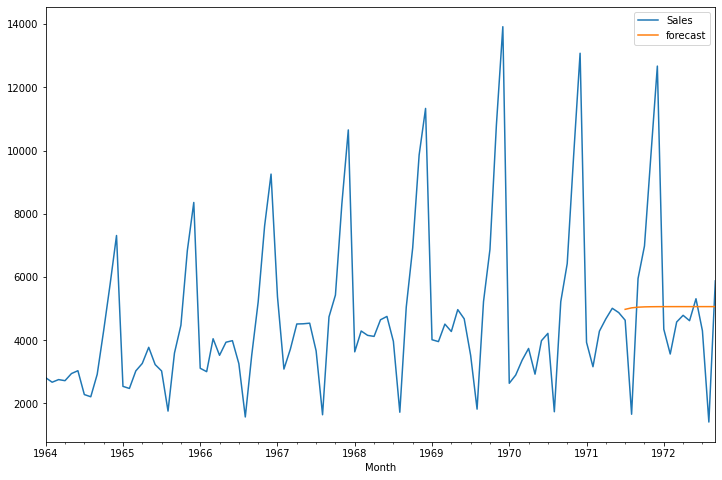

In [100]:
df['forecast']=model_fit.predict(start=90,end=104,dynamic=True)
df[['Sales','forecast']].plot(figsize=(12,8))

The ARIMA model does not work well since the data is seasonal

# ARIMAX

In [101]:
model=sm.tsa.statespace.SARIMAX(df['Sales'],order=(1, 1, 1),seasonal_order=(1,1,1,12))
results=model.fit()

C:\Users\owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


### Testing

<AxesSubplot:xlabel='Month'>

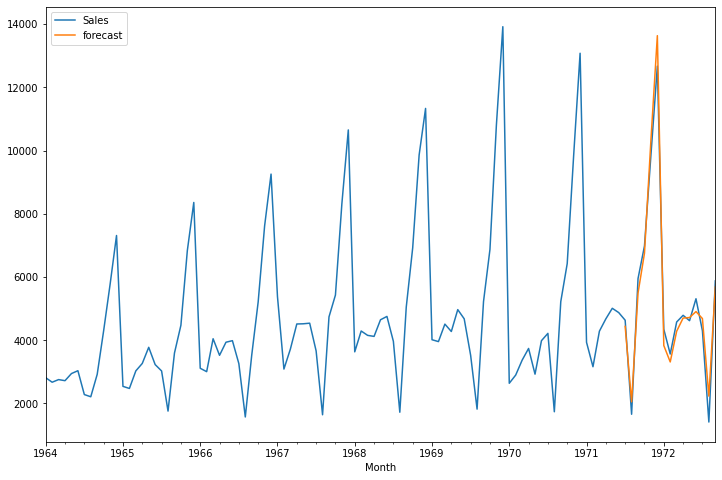

In [102]:
df['forecast']=results.predict(start=90,end=104,dynamic=True)
df[['Sales','forecast']].plot(figsize=(12,8))

### Forecasting

In [103]:
future_dates=[df.index[-1]+ DateOffset(months=x)for x in range(0,24)]

In [104]:
future_datest_df=pd.DataFrame(index=future_dates[1:],columns=df.columns)

In [105]:
future_datest_df.tail()

,Sales,Seasonal First Difference,forecast
1974-04-01,NaN,NaN,NaN
1974-05-01,NaN,NaN,NaN
1974-06-01,NaN,NaN,NaN
1974-07-01,NaN,NaN,NaN
1974-08-01,NaN,NaN,NaN


In [106]:
future_df=pd.concat([df,future_datest_df])

<AxesSubplot:>

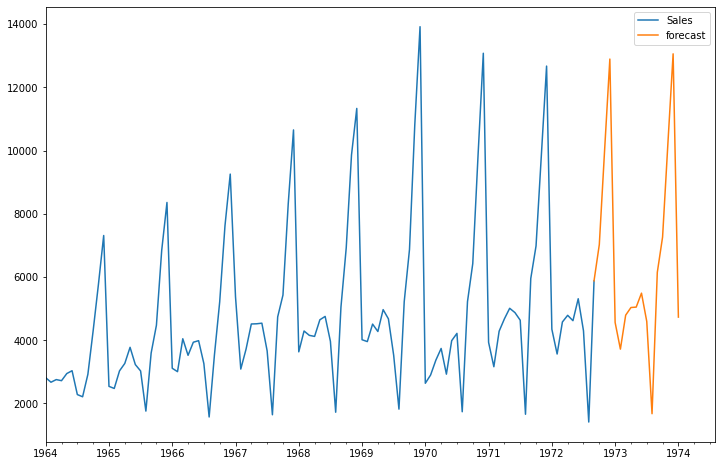

In [107]:
future_df['forecast'] = results.predict(start = 104, end = 120, dynamic= True)  
future_df[['Sales', 'forecast']].plot(figsize=(12, 8)) 

# Evaluating Test Results

In [108]:
# Creating a dataframe with the expected and predicted sales values
testing = pd.DataFrame.from_dict({'Expected':[], 'Predicted': []})

testing['Expected'] = df['Sales'].iloc[90:]
testing['Predicted'] = df['forecast'].iloc[90:]

testing.head()

,Expected,Predicted
Month,,
1971-07-01,4633.0,4437.324807
1971-08-01,1659.0,2050.747634
1971-09-01,5951.0,5493.376562
1971-10-01,6981.0,6752.038903
1971-11-01,9851.0,10327.297367


### Mean Squared Error

In [109]:
errors = mean_squared_error(testing['Expected'], testing['Predicted'])
errors

203966.41450866996

### Root Mean Squared Error

In [110]:
rmse = mean_squared_error(testing['Expected'], testing['Predicted'], squared=False)
rmse

451.62641033122713

### Mean Absolute Error

In [111]:
mae = mean_absolute_error(testing['Expected'], testing['Predicted'])
mae

383.9597120688878